Разработать модель машинного обучения, способный классифицировать статьи на фейковые и нет.

In [39]:
import numpy as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re

In [14]:
!git clone https://github.com/klyambda/fake-news.git

Cloning into 'fake-news'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 6), reused 18 (delta 2), pack-reused 0
Unpacking objects: 100% (26/26), done.


### Импортируем датасет и посмотрим на наши данные.

In [35]:
train = pd.read_csv('fake-news/dataset/train.csv')
test = pd.read_csv('fake-news/dataset/test.csv')

train.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [36]:
train.tail(5)

,id,title,author,text,label
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [58]:
# проверяем есть ли пропущенные значения в некоторых ячейках
print(train.isna().sum())
print()
print(test.isna().sum())

id        0
title     0
author    0
text      0
label     0
dtype: int64

id        0
title     0
author    0
text      0
dtype: int64


In [53]:
# заполняем пропущенные значения пустыми строками
train = train.fillna('')
test = test.fillna('')

In [57]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20800 non-null  object
 2   author  20800 non-null  object
 3   text    20800 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [61]:
# проверка на наличие дубликатов
print('train: ', train.duplicated().sum())
print('test: ', test.duplicated().sum())

train:  0
test:  0


Распределение по классам на фейковые и нефейковые статьи сбалансировано.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


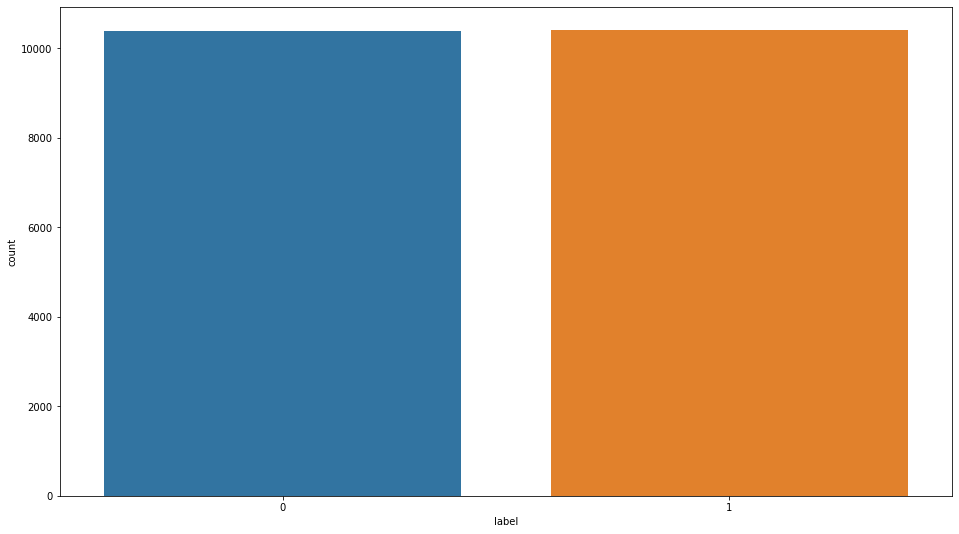

In [56]:
plt.figure(figsize=(16, 9))
sns.countplot(train['label'])

### Предобработка текста